### Credits to Neumann et al. (2023) http://dx.doi.org/10.2139/ssrn.4173442

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
import seaborn as sns
import os

In [40]:
EXPORT = 40
CO2L = 0.10
CLUSTERS = 4
H = 3
LL = "3.0"
DISCOUNT_RATE = 0.13

RUN = "decr_13_3H_ws"
CATEGORY = "postnetworks"
SCENARIO = f"elec_s_{CLUSTERS}_ec_lc{LL}_Co2L{CO2L}0_{H}H_2030_{DISCOUNT_RATE}_DF_{EXPORT}export"

#OVERRIDES = PATH + "pypsa-eur-sec/data/override_component_attrs"

PREFIX = "/mnt/c/Users/scl38887/Documents/git/aldehyde/"
OUTPUT = PREFIX + "results"
INPUT = PREFIX + f"workflow/subworkflows/pypsa-earth-sec/results/{RUN}/{CATEGORY}/{SCENARIO}.nc"
OUTPUT_SCENARIO = f"{OUTPUT}/{RUN}/graphics/heatmaps/{SCENARIO}"
OUTPUT_RAW = f"{OUTPUT}/{RUN}/graphics/heatmaps/"

In [41]:
n = pypsa.Network(INPUT)

INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.10_3H_2030_0.13_DF_40export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


#### Plot Prices

In [4]:
def get_nodal_prices(n):
    return (
        n.buses_t.marginal_price.mean()
        .groupby([n.buses.location, n.buses.carrier])
        .first()
        .unstack()
    )

In [5]:
df = get_nodal_prices(n)

In [6]:
def plot_price_duration_curve(n, carrier, fn=None):
    df = n.buses_t.marginal_price.loc[:, n.buses.carrier == carrier]

    df = df.stack()

    to_plot = df.sort_values(ascending=False).reset_index(drop=True)

    to_plot.index = [i / len(df) * 100 for i in to_plot.index]

    fig, ax = plt.subplots(figsize=(4, 2.5))
    to_plot.plot(
        ax=ax,
    )
    plt.xlabel("share of snapshots and nodes [%]")
    plt.ylabel("nodal price [EUR/MWh]")
    plt.axvline(0, linewidth=0.5, linestyle=":", color="grey")
    plt.axvline(100, linewidth=0.5, linestyle=":", color="grey")
    plt.axhline(0, linewidth=0.5, linestyle=":", color="grey")

    if carrier == "H2":
        title = "Hydrogen"
        plt.ylim([-20, 350])
    elif carrier == "AC":
        title = "Electricity"
        plt.ylim([-100, 400])
    else:
        title = carrier

    plt.title(title, fontsize=12, color="#343434")

    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

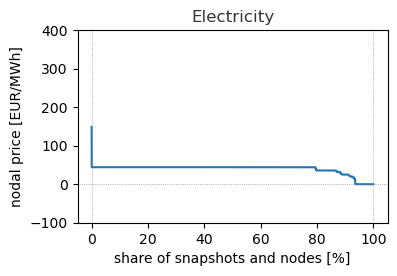

In [7]:
plot_price_duration_curve(n, "AC")

### Plot heatmaps

In [20]:
def plot_cf_heatmap(
    df, vmin=0, vmax=80, cmap="Greens", label="capacity factors [%]", fn=True
):
    fig, ax = plt.subplots(figsize=(6, 2.5))
    sns.heatmap(
        df,
        cmap=cmap,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cbar_kws=dict(label=label, extend="max"),
    )
    plt.ylabel("hour of the day")
    plt.xlabel("day of the year")
    plt.yticks(rotation=0)
    plt.title(carrier, fontsize=12)
    plt.tight_layout()
    # plt.annotate("Style from: Neumann et al. (2023) \n http://dx.doi.org/10.2139/ssrn.4173442", 
    #         xy=(0.9, -0.8),  # Coordinates of the text, adjust as needed
    #         xycoords='axes fraction',  # Use normalized axes coordinates
    #         textcoords='offset points',  # Use offset from xy
    #         size=7,  # Adjust the size of the text
    #         xytext=(0, 10),  # Offset from the xy point
    #         ha='center',  # Horizontal alignment
    #         color='gray')  # Adjust the color of the text
    if fn:
        if not isinstance(fn, str):
            fn = f"{OUTPUT_SCENARIO}/cf-ts-{carrier}.pdf"
            if not os.path.exists(OUTPUT_SCENARIO):
                os.makedirs(OUTPUT_SCENARIO)
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [21]:
def unstack_day_hour(cfc):
    df = cfc.groupby(cfc.index.hour).agg(list)

    columns = pd.date_range(cfc.index[0], cfc.index[-1], freq="D").strftime("%-d %b")

    return pd.DataFrame(df.tolist(), index=df.index, columns=columns)

#### AC and H2 price heatmap

In [42]:
cf = n.buses_t.marginal_price.groupby(n.buses.carrier, axis=1).mean()

In [43]:
# for carrier in cf.columns:
for carrier in ["AC", "H2"]:
    cfc = cf[carrier]
    df = unstack_day_hour(cfc)
    vmax = np.ceil(cfc.quantile(0.99) / 10) * 10
    if carrier in ["AC", "H2"]:
        vmax = 300
    plot_cf_heatmap(
        df,
        cmap="Spectral_r",
        label="Nodal Price [EUR/MWh]",
        vmax=vmax,
        fn=True,
    )

#### Plot SOC heatmaps

In [14]:
def aggregate_techs(tech):
    if "solar thermal" in tech:
        return "solar thermal"
    elif "solar" in tech:
        return "solar PV"
    elif "offwind" in tech:
        return "offshore wind"
    elif "onwind" in tech:
        return "onshore wind"
    elif "ror" in tech:
        return "run of river"
    elif "ground heat pump" in tech:
        return "ground-sourced heat pump"
    elif "air heat pump" in tech:
        return "air-sourced heat pump"
    elif "water tank" in tech:
        return "thermal energy storage"
    elif tech == "H2":
        return "hydrogen storage"
    elif tech == "Li ion":
        return "electric vehicle batteries"
    elif "gas boiler" in tech:
        return "gas boiler"
    elif "resistive heater" in tech:
        return "resistive heater"
    elif "CHP" in tech:
        return "CHP"
    else:
        return tech

In [24]:
cf = (
    n.stores_t.e.groupby(n.stores.carrier, axis=1).sum()
    / n.stores.e_nom_opt.groupby(n.stores.carrier).sum()
    * 100
)
cf = cf.groupby(cf.columns.map(aggregate_techs), axis=1).mean()

In [25]:
for carrier in ["battery", "hydrogen storage", "electric vehicle batteries", "thermal energy storage"]: #cf.columns:
    cfc = cf[carrier]
    df = unstack_day_hour(cfc)
    plot_cf_heatmap(df, cmap="Purples", vmin=0, vmax=100, label="SOC [%]", fn=True)

#### Plot CFs of wind and solar 

In [26]:
cf = n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean() * 100
cf = cf.groupby(cf.columns.map(aggregate_techs), axis=1).mean()

In [27]:
for carrier in cf.columns:
    cfc = cf[carrier]
    df = unstack_day_hour(cfc)
    plot_cf_heatmap(df, cmap="Blues", fn=f"{OUTPUT_RAW}/cf-raw-ts-{carrier}.pdf")

#### Plot CFs of links (incl. electrolysis)

In [44]:
cf = (
    n.links_t.p0.groupby(n.links.carrier, axis=1).sum()
    / n.links.p_nom_opt.groupby(n.links.carrier).sum()
    * 100
)
cf = cf.groupby(cf.columns.map(aggregate_techs), axis=1).mean()

In [45]:
bidirectional = (cf < 0).any()

In [46]:
cfb = cf.loc[:, ~bidirectional]
for carrier in cfb.columns:
    cfc = cfb[carrier]
    df = unstack_day_hour(cfc)
    plot_cf_heatmap(df, cmap="Reds", vmax=100)

#### V2G and BEV

In [66]:
cf = n.links_t.p_max_pu.groupby(n.links.carrier, axis=1).mean() * 100
cf = cf.groupby(cf.columns.map(aggregate_techs), axis=1).mean()

In [67]:
for carrier in cf.columns:
    cfc = cf[carrier]
    df = unstack_day_hour(cfc)
    plot_cf_heatmap(df, cmap="viridis", vmin=40, vmax=100)

#### Plot COP of heatpumps

In [31]:
cf = n.links_t.efficiency.groupby(n.links.carrier, axis=1).mean()
cf = cf.groupby(cf.columns.map(aggregate_techs), axis=1).mean()

In [32]:
for carrier in cf.columns:
    cfc = cf[carrier]
    df = unstack_day_hour(cfc)
    plot_cf_heatmap(
        df,
        vmin=1,
        vmax=4,
        cmap="Greens",
        label="COP [-]",
        fn=f"{OUTPUT_RAW}/cop-ts-{carrier}.pdf",
    )